# Neural Network with SMOTE

This notebook trains a neural network on the dataset preprocessed with SMOTE. This aims to compare the performance of oversampling (SMOTE) vs. class weighting for Neural Networks.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, accuracy_score

from src.preprocessing_pipeline import build_preprocessed_data

2025-11-29 09:34:29.429220: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-29 09:34:29.549324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-29 09:34:29.549352: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-29 09:34:29.552681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-29 09:34:29.584718: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("Loading and preprocessing data (WITH SMOTE)...")
data = build_preprocessed_data(use_smote=True)

# Ensure correct types
X_train = data["X_train_std"].astype('float32')
y_train = data["Y_train"].astype('int32')
X_val = data["X_val_std"].astype('float32')
y_val = data["Y_val"].astype('int32')
X_test = data["X_test_std"].astype('float32')
y_test = data["Y_test"].astype('int32')

print("Training shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Loading and preprocessing data (WITH SMOTE)...
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
Applying SMOTE...
SMOTE done.
Training shape: (5380328, 52) (5380328,)
Validation shape: (460504, 52) (460504,)
Test shape: (460505, 52) (460505,)


In [3]:
# Neural Network Model
def build_model(input_dim, num_classes):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

num_classes = len(np.unique(y_train))
model = build_model(input_dim=X_train.shape[1], num_classes=num_classes)
model.summary()

2025-11-29 09:35:45.273263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-29 09:35:45.423118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-29 09:35:45.423162: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-29 09:35:45.433442: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-11-29 09:35:45.433956: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                3392      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5604 (21.89 KB)
Trainable params: 5604 (21.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [4]:
# Train Model (NO Class Weights, relying on SMOTE)
print("Training Neural Network...")
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=2048,
    callbacks=[early_stopping],
    verbose=1
)

Training Neural Network...
Epoch 1/50


2025-11-29 09:35:58.784751: I external/local_xla/xla/service/service.cc:168] XLA service 0x77b6b433ea70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-29 09:35:58.784780: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-11-29 09:35:58.800801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-29 09:35:58.834624: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1764426958.891123   42564 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2628/2628 [==============================] - 10s 3ms/step - loss: 0.7776 - accuracy: 0.6499 - val_loss: 0.3285 - val_accuracy: 0.9216
Epoch 2/50
2628/2628 [==============================] - 8s 3ms/step - loss: 0.6560 - accuracy: 0.7135 - val_loss: 0.3439 - val_accuracy: 0.9067
Epoch 3/50
2628/2628 [==============================] - 8s 3ms/step - loss: 0.6306 - accuracy: 0.7260 - val_loss: 0.3288 - val_accuracy: 0.9131
Epoch 4/50
2628/2628 [==============================] - 8s 3ms/step - loss: 0.6173 - accuracy: 0.7323 - val_loss: 0.3452 - val_accuracy: 0.9064
Epoch 5/50
2628/2628 [==============================] - 7s 3ms/step - loss: 0.6086 - accuracy: 0.7365 - val_loss: 0.3302 - val_accuracy: 0.9161
Epoch 6/50
2628/2628 [==============================] - 7s 3ms/step - loss: 0.6024 - accuracy: 0.7395 - val_loss: 0.3347 - val_accuracy: 0.9127


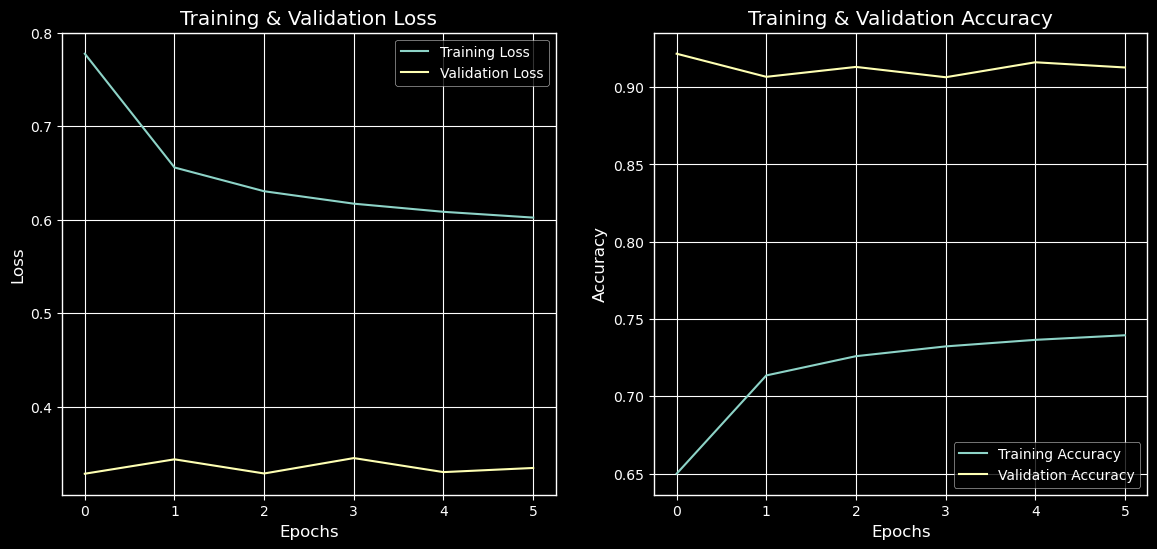

In [7]:
plt.style.use('dark_background')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left Plot: Loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Right Plot: Accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

In [8]:
# Evaluate on Validation Set
print("Evaluating on Validation Set...")
y_pred_val_prob = model.predict(X_val)
y_pred_val = np.argmax(y_pred_val_prob, axis=1)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("\nClassification Report (Validation):\n")
print(classification_report(y_val, y_pred_val))

Evaluating on Validation Set...
14391/14391 [==============================] - 15s 1ms/step
Validation Accuracy: 0.9216163160363428

Classification Report (Validation):

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    448361
           1       0.10      0.09      0.09     11185
           2       0.01      0.27      0.03       738
           3       0.02      0.35      0.03       220

    accuracy                           0.92    460504
   macro avg       0.28      0.41      0.28    460504
weighted avg       0.96      0.92      0.94    460504



In [9]:
# Evaluate on Test Set
print("Evaluating on Test Set...")
y_pred_test_prob = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test_prob, axis=1)

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report (Test):\n")
print(classification_report(y_test, y_pred_test))

Evaluating on Test Set...
14391/14391 [==============================] - 14s 1ms/step
Test Accuracy: 0.9218966135003963

Classification Report (Test):

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    448364
           1       0.10      0.08      0.09     11185
           2       0.02      0.30      0.03       734
           3       0.02      0.41      0.04       222

    accuracy                           0.92    460505
   macro avg       0.28      0.44      0.28    460505
weighted avg       0.96      0.92      0.94    460505

